<a href="https://colab.research.google.com/github/SridharSubbu/GANs/blob/main/GANs_Assign3_23070149026_Sridhar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape and add a channel dimension
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Define VAE architecture
latent_dim = 2

In [ ]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

In [ ]:

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# Train the VAE
# vae.fit(x_train, x_train, epochs=30, batch_size=128)

# Compile the VAE
vae.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')


In [ ]:
# Train the VAE
vae.fit(x_train, x_train, epochs=30, batch_size=128)

# Calculate reconstruction error for test set
x_test_pred = vae.predict(x_test)
reconstruction_loss = tf.reduce_mean(tf.square(x_test_pred - x_test), axis=(1,2,3))

# Set threshold for anomaly detection
threshold = np.mean(reconstruction_loss) + np.std(reconstruction_loss)

# Identify anomalies
anomalies = np.where(reconstruction_loss > threshold)[0]

print("Indices of anomalies:", anomalies)

Epoch 1/30
469/469 [==============================] - 82s 171ms/step - loss: 0.1150
Epoch 2/30
469/469 [==============================] - 84s 179ms/step - loss: 0.1120
Epoch 3/30
469/469 [==============================] - 83s 177ms/step - loss: 0.1120
Epoch 4/30
469/469 [==============================] - 83s 178ms/step - loss: 0.1120
Epoch 5/30
469/469 [==============================] - 82s 176ms/step - loss: 0.1120
Epoch 6/30
469/469 [==============================] - 84s 178ms/step - loss: 0.1120
Epoch 7/30
469/469 [==============================] - 83s 178ms/step - loss: 0.1120
Epoch 8/30
469/469 [==============================] - 83s 176ms/step - loss: 0.1120
Epoch 9/30
469/469 [==============================] - 83s 177ms/step - loss: 0.1120
Epoch 10/30
469/469 [==============================] - 82s 176ms/step - loss: 0.1120
Epoch 11/30
469/469 [==============================] - 83s 178ms/step - loss: 0.1120
Epoch 12/30
469/469 [==============================] - 83s 177ms/step - lo

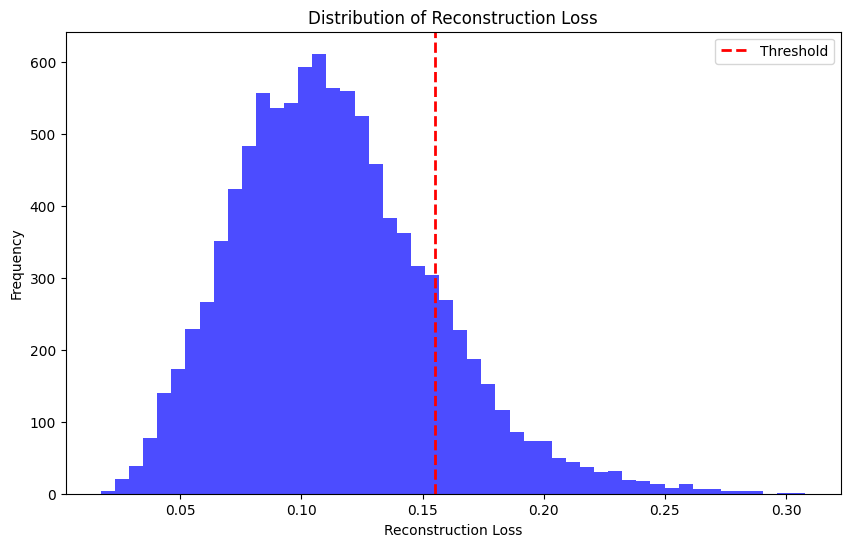

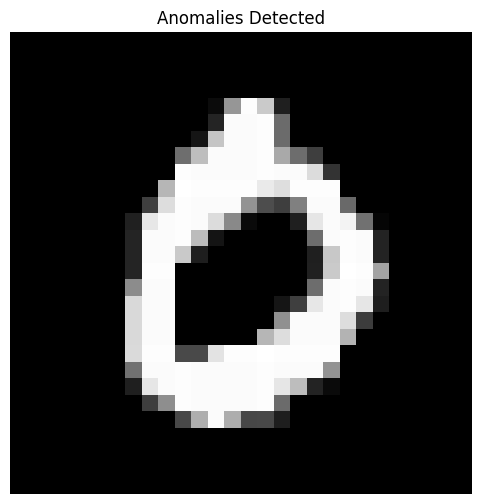

In [ ]:
import matplotlib.pyplot as plt

# Plot reconstruction loss
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss')
plt.legend()
plt.show()

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.imshow(x_test[anomalies[0]].reshape(-1, 28), cmap='gray')
plt.title('Anomalies Detected')
plt.axis('off')
plt.show()
